In [221]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model
from keras.layers import Dropout
import xgboost
import pickle

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators.**

# DATA COLLECTION

In [222]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='D8JHWTNSXO7M9VKV', output_format='pandas')

In [223]:
data = ts.get_intraday(symbol='MSFT',interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

,open,high,low,close,volume
date,,,,,
2021-07-09 20:00:00,277.8000,277.94,277.8000,277.94,1600.0
2021-07-09 19:45:00,277.8000,277.80,277.7900,277.79,1233.0
2021-07-09 19:30:00,277.7900,277.80,277.7900,277.80,1053.0
2021-07-09 19:15:00,277.7800,277.78,277.7800,277.78,220.0
2021-07-09 19:00:00,277.7499,277.75,277.7499,277.75,1611.0
...,...,...,...,...,...
2021-06-01 05:45:00,251.3000,251.30,251.2900,251.29,598.0
2021-06-01 05:00:00,251.0000,251.35,251.0000,251.35,674.0
2021-06-01 04:45:00,250.9900,250.99,250.9900,250.99,297.0


# INDICATORS CALCULATION

In [224]:
from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key='D8JHWTNSXO7M9VKV', output_format='pandas')

## 1. Rate of Change (ROC)

In [225]:
indicator_roc = ti.get_roc(symbol='MSFT', interval='15min', time_period=20)
indicator_roc = indicator_roc[0]
indicator_roc

,ROC
date,
2021-06-01 10:15:00,-0.9117
2021-06-01 10:30:00,-0.8731
2021-06-01 10:45:00,-0.9164
2021-06-01 11:00:00,-1.3527
2021-06-01 11:15:00,-1.2615
...,...
2021-07-09 19:00:00,0.1406
2021-07-09 19:15:00,0.2563
2021-07-09 19:30:00,0.2345


## 2. Simple Moving Average (SMA)

In [226]:
indicator_sma = ti.get_sma(symbol='MSFT', interval='15min', time_period=20)
indicator_sma = indicator_sma[0]
indicator_sma

,SMA
date,
2021-06-01 10:00:00,250.7222
2021-06-01 10:15:00,250.6077
2021-06-01 10:30:00,250.4982
2021-06-01 10:45:00,250.3832
2021-06-01 11:00:00,250.2132
...,...
2021-07-09 19:00:00,277.6570
2021-07-09 19:15:00,277.6925
2021-07-09 19:30:00,277.7250


## 3. Relative Strength Index (RSI)

In [227]:
indicator_rsi = ti.get_rsi(symbol='MSFT', interval='15min', time_period=20)
indicator_rsi = indicator_rsi[0]
indicator_rsi

,RSI
date,
2021-06-01 10:15:00,31.2030
2021-06-01 10:30:00,29.9604
2021-06-01 10:45:00,30.5668
2021-06-01 11:00:00,26.9342
2021-06-01 11:15:00,28.9753
...,...
2021-07-09 19:00:00,53.8171
2021-07-09 19:15:00,54.1876
2021-07-09 19:30:00,54.4440


## 4. Bolling Bands (BBANDS)

In [228]:
indicator_bb = ti.get_bbands(symbol='MSFT', interval='15min', time_period=20)
indicator_bb = indicator_bb[0]
indicator_bb

,Real Middle Band,Real Lower Band,Real Upper Band
date,,,
2021-07-09 20:00:00,277.7805,277.3708,278.1902
2021-07-09 19:45:00,277.7525,277.3146,278.1904
2021-07-09 19:30:00,277.7250,277.2341,278.2159
2021-07-09 19:15:00,277.6925,277.1432,278.2418
2021-07-09 19:00:00,277.6570,277.0466,278.2674
...,...,...,...
2021-06-01 11:00:00,250.2132,248.3966,252.0298
2021-06-01 10:45:00,250.3832,248.8281,251.9383
2021-06-01 10:30:00,250.4982,249.1323,251.8641


**Merge indicators to data**

In [229]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df = original_df.iloc[::-1]
original_df.to_csv('./DATA/MSFT.csv')
original_df

,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band
date,,,,,,,,,,,
2021-06-01 10:15:00,250.0100,250.06,248.8700,248.88,815307.0,-0.9117,250.6077,31.2030,250.6077,249.5357,251.6797
2021-06-01 10:30:00,248.8700,248.87,247.9100,248.64,1142659.0,-0.8731,250.4982,29.9604,250.4982,249.1323,251.8641
2021-06-01 10:45:00,248.6500,249.13,248.5400,248.69,822538.0,-0.9164,250.3832,30.5668,250.3832,248.8281,251.9383
2021-06-01 11:00:00,248.6600,248.90,247.6800,247.95,850538.0,-1.3527,250.2132,26.9342,250.2132,248.3966,252.0298
2021-06-01 11:15:00,247.9400,250.50,247.6700,248.12,1663982.0,-1.2615,250.0547,28.9753,250.0547,248.0941,252.0153
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-09 19:00:00,277.7499,277.75,277.7499,277.75,1611.0,0.1406,277.6570,53.8171,277.6570,277.0466,278.2674
2021-07-09 19:15:00,277.7800,277.78,277.7800,277.78,220.0,0.2563,277.6925,54.1876,277.6925,277.1432,278.2418
2021-07-09 19:30:00,277.7900,277.80,277.7900,277.80,1053.0,0.2345,277.7250,54.4440,277.7250,277.2341,278.2159


# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [230]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[248.88],
       [248.64],
       [248.69],
       ...,
       [277.8 ],
       [277.79],
       [277.94]])

In [231]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645],
       [0.14742903],
       [0.14876808],
       ...,
       [0.92836101],
       [0.9280932 ],
       [0.93211034]])

In [232]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [233]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 1)
Size validate:  (157, 60, 1)
Size test:  (157, 60, 1)


### b. Train Model

In [234]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

Epoch 1/20
40/40 [==============================] - 11s 73ms/step - loss: 0.0488 - val_loss: 0.0133
Epoch 2/20
40/40 [==============================] - 2s 47ms/step - loss: 0.0011 - val_loss: 4.3271e-04
Epoch 3/20
40/40 [==============================] - 2s 54ms/step - loss: 4.1918e-04 - val_loss: 6.0258e-04
Epoch 4/20
40/40 [==============================] - 2s 58ms/step - loss: 4.6533e-04 - val_loss: 5.7164e-04
Epoch 5/20
40/40 [==============================] - 2s 51ms/step - loss: 3.9711e-04 - val_loss: 8.2834e-04
Epoch 6/20
40/40 [==============================] - 2s 50ms/step - loss: 4.2792e-04 - val_loss: 6.3604e-04
Epoch 7/20
40/40 [==============================] - 2s 52ms/step - loss: 3.6285e-04 - val_loss: 6.8309e-04
Epoch 8/20
40/40 [==============================] - 2s 56ms/step - loss: 3.8491e-04 - val_loss: 3.8971e-04
Epoch 9/20
40/40 [==============================] - 2s 58ms/step - loss: 4.0363e-04 - val_loss: 6.3689e-04
Epoch 10/20
40/40 [=============================

### c. Test Model

In [235]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [236]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [237]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-237-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1476,2021-07-07 11:30:00,278.8400,278.97,278.5500,278.9300,624508.0,-0.0681,279.1518,51.1594,279.1518,278.4927,279.8108,279.125031
1477,2021-07-07 11:45:00,278.9450,279.35,278.5200,279.3314,570070.0,0.1188,279.1683,54.7801,279.1683,278.5087,279.8279,279.086639
1478,2021-07-07 12:00:00,279.3200,279.98,279.3200,279.6900,510257.0,0.1576,279.1903,57.7271,279.1903,278.4930,279.8876,279.069580
1479,2021-07-07 12:15:00,279.7050,280.23,279.6600,280.0300,527682.0,0.3045,279.2328,60.3087,279.2328,278.4454,280.0202,279.089020
1480,2021-07-07 12:30:00,280.0500,280.24,279.7000,279.7200,661221.0,0.1575,279.2548,56.9696,279.2548,278.4393,280.0703,279.151794
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,2021-07-09 19:00:00,277.7499,277.75,277.7499,277.7500,1611.0,0.1406,277.6570,53.8171,277.6570,277.0466,278.2674,277.749908
1629,2021-07-09 19:15:00,277.7800,277.78,277.7800,277.7800,220.0,0.2563,277.6925,54.1876,277.6925,277.1432,278.2418,277.740509
1630,2021-07-09 19:30:00,277.7900,277.80,277.7900,277.8000,1053.0,0.2345,277.7250,54.4440,277.7250,277.2341,278.2159,277.730591
1631,2021-07-09 19:45:00,277.8000,277.80,277.7900,277.7900,1233.0,0.1984,277.7525,54.2841,277.7525,277.3146,278.1904,277.722076


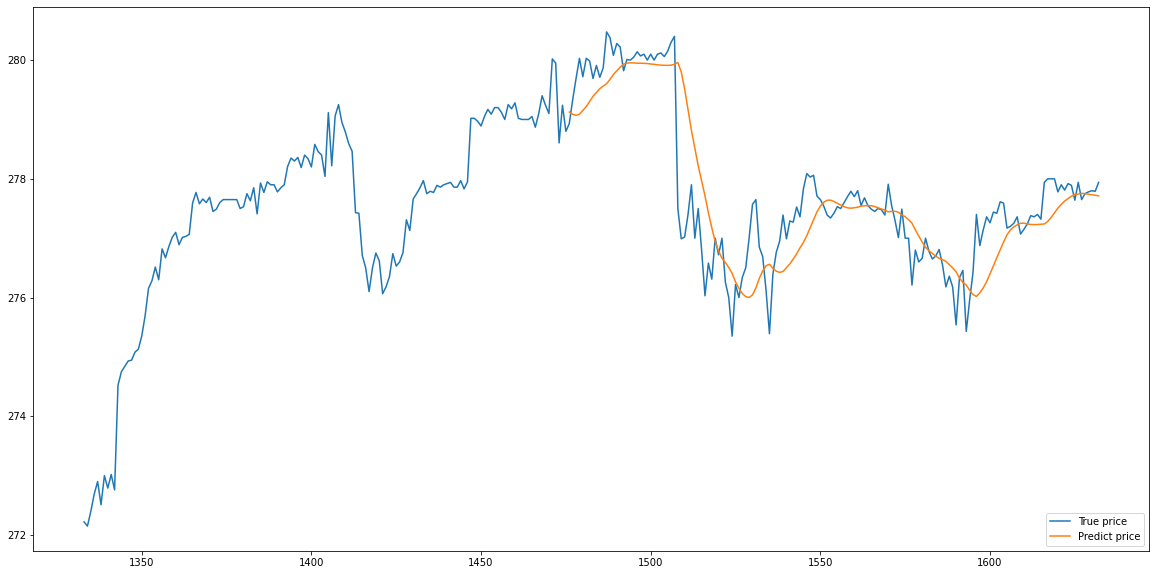

In [239]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [240]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 2.4888e+02, -9.1170e-01],
       [ 2.4864e+02, -8.7310e-01],
       [ 2.4869e+02, -9.1640e-01],
       ...,
       [ 2.7780e+02,  2.3450e-01],
       [ 2.7779e+02,  1.9840e-01],
       [ 2.7794e+02,  2.0190e-01]])

In [241]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645, 0.21469751],
       [0.14742903, 0.22363455],
       [0.14876808, 0.21360932],
       ...,
       [0.92836101, 0.48007687],
       [0.9280932 , 0.47171865],
       [0.93211034, 0.472529  ]])

In [242]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [243]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 2)
Size validate:  (157, 60, 2)
Size test:  (157, 60, 2)


In [244]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
40/40 [==============================] - 7s 87ms/step - loss: 0.0687 - val_loss: 0.0096
Epoch 2/20
40/40 [==============================] - 3s 65ms/step - loss: 8.8451e-04 - val_loss: 5.6092e-04
Epoch 3/20
40/40 [==============================] - 2s 57ms/step - loss: 3.7670e-04 - val_loss: 3.7032e-04
Epoch 4/20
40/40 [==============================] - 2s 58ms/step - loss: 3.4823e-04 - val_loss: 6.3345e-04
Epoch 5/20
40/40 [==============================] - 2s 58ms/step - loss: 3.2663e-04 - val_loss: 6.1443e-04
Epoch 6/20
40/40 [==============================] - 2s 60ms/step - loss: 2.9800e-04 - val_loss: 2.7297e-04
Epoch 7/20
40/40 [==============================] - 2s 62ms/step - loss: 3.3350e-04 - val_loss: 3.4382e-04
Epoch 8/20
40/40 [==============================] - 2s 59ms/step - loss: 3.2505e-04 - val_loss: 3.6332e-04
Epoch 9/20
40/40 [==============================] - 2s 61ms/step - loss: 3.1400e-04 - val_loss: 3.6991e-04
Epoch 10/20
40/40 [==========================

In [245]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [246]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]
predictions

array([278.84494, 278.798  , 278.7993 , 278.8427 , 278.9416 , 279.02545,
       279.14197, 279.25674, 279.33328, 279.40576, 279.44574, 279.49097,
       279.57593, 279.6489 , 279.69604, 279.7533 , 279.75754, 279.71362,
       279.73737, 279.7435 , 279.77222, 279.80518, 279.81076, 279.79248,
       279.74286, 279.71344, 279.67044, 279.64273, 279.64252, 279.638  ,
       279.65396, 279.68268, 279.6966 , 279.44083, 279.05527, 278.61978,
       278.2312 , 277.96295, 277.6735 , 277.45724, 277.21982, 276.91684,
       276.66757, 276.43002, 276.29453, 276.1833 , 276.13217, 276.03464,
       275.9012 , 275.69815, 275.5594 , 275.42722, 275.34357, 275.46252,
       275.7137 , 276.04727, 276.36966, 276.55203, 276.68323, 276.6783 ,
       276.57108, 276.5469 , 276.55026, 276.59973, 276.67023, 276.7257 ,
       276.78452, 276.8762 , 277.00558, 277.15237, 277.28687, 277.44174,
       277.56693, 277.66574, 277.68796, 277.64578, 277.57013, 277.51523,
       277.47333, 277.476  , 277.5384 , 277.5607 , 

In [247]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-247-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1476,2021-07-07 11:30:00,278.8400,278.97,278.5500,278.9300,624508.0,-0.0681,279.1518,51.1594,279.1518,278.4927,279.8108,278.844940
1477,2021-07-07 11:45:00,278.9450,279.35,278.5200,279.3314,570070.0,0.1188,279.1683,54.7801,279.1683,278.5087,279.8279,278.798004
1478,2021-07-07 12:00:00,279.3200,279.98,279.3200,279.6900,510257.0,0.1576,279.1903,57.7271,279.1903,278.4930,279.8876,278.799286
1479,2021-07-07 12:15:00,279.7050,280.23,279.6600,280.0300,527682.0,0.3045,279.2328,60.3087,279.2328,278.4454,280.0202,278.842712
1480,2021-07-07 12:30:00,280.0500,280.24,279.7000,279.7200,661221.0,0.1575,279.2548,56.9696,279.2548,278.4393,280.0703,278.941589
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,2021-07-09 19:00:00,277.7499,277.75,277.7499,277.7500,1611.0,0.1406,277.6570,53.8171,277.6570,277.0466,278.2674,277.623566
1629,2021-07-09 19:15:00,277.7800,277.78,277.7800,277.7800,220.0,0.2563,277.6925,54.1876,277.6925,277.1432,278.2418,277.627594
1630,2021-07-09 19:30:00,277.7900,277.80,277.7900,277.8000,1053.0,0.2345,277.7250,54.4440,277.7250,277.2341,278.2159,277.645020
1631,2021-07-09 19:45:00,277.8000,277.80,277.7900,277.7900,1233.0,0.1984,277.7525,54.2841,277.7525,277.3146,278.1904,277.661713


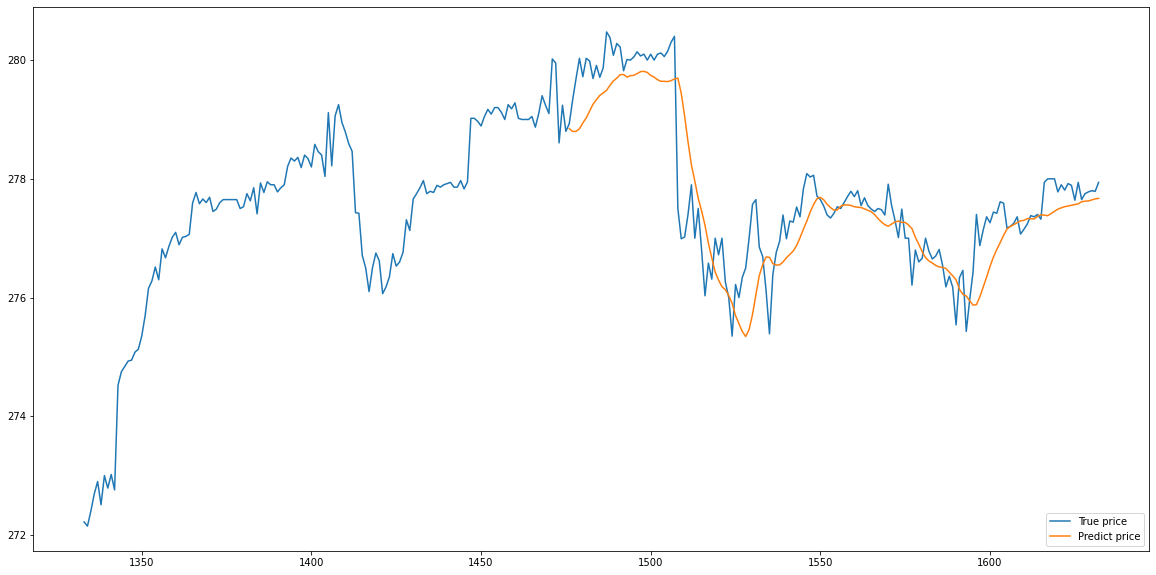

In [249]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

#### + RSI

#### + BBANDS

#### + BBANDS + ROC

#### + BBANDS + RSI

#### + BBANDS + SMA

#### + ROC + RSI

#### + ROC + SMA

#### + RSI + SMA

#### + BBANDS + ROC + RSI

#### + BBANDS + ROC + SMA

#### + BBANDS + RSI + SMA

#### + ROC + RSI + SMA

#### + BBANDS + ROC + RSI + SMA

### e. Predict Future

In [253]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 2. RNN

### a. Prepare Input

In [254]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[248.88],
       [248.64],
       [248.69],
       ...,
       [277.8 ],
       [277.79],
       [277.94]])

In [255]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645],
       [0.14742903],
       [0.14876808],
       ...,
       [0.92836101],
       [0.9280932 ],
       [0.93211034]])

In [256]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [257]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 1)
Size validate:  (157, 60, 1)
Size test:  (157, 60, 1)


### b. Train Model

In [258]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25
40/40 [==============================] - 12s 137ms/step - loss: 0.0660 - val_loss: 0.0057
Epoch 2/25
40/40 [==============================] - 4s 97ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 3/25
40/40 [==============================] - 4s 102ms/step - loss: 0.0034 - val_loss: 0.0123
Epoch 4/25
40/40 [==============================] - 4s 105ms/step - loss: 0.0039 - val_loss: 7.2018e-04
Epoch 5/25
40/40 [==============================] - 4s 107ms/step - loss: 0.0033 - val_loss: 0.0028
Epoch 6/25
40/40 [==============================] - 4s 108ms/step - loss: 0.0026 - val_loss: 0.0027
Epoch 7/25
40/40 [==============================] - 4s 109ms/step - loss: 0.0028 - val_loss: 0.0020
Epoch 8/25
40/40 [==============================] - 4s 111ms/step - loss: 0.0028 - val_loss: 7.6660e-04
Epoch 9/25
40/40 [==============================] - 4s 111ms/step - loss: 0.0025 - val_loss: 0.0028
Epoch 10/25
40/40 [==============================] - 5s 114ms/step - loss: 0.0027 - val_loss

### c. Test Model

In [260]:
model_rnn = load_model('./MODEL/RNN.h5')

In [261]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [262]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-262-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1476,2021-07-07 11:30:00,278.8400,278.97,278.5500,278.9300,624508.0,-0.0681,279.1518,51.1594,279.1518,278.4927,279.8108,277.831390
1477,2021-07-07 11:45:00,278.9450,279.35,278.5200,279.3314,570070.0,0.1188,279.1683,54.7801,279.1683,278.5087,279.8279,277.844177
1478,2021-07-07 12:00:00,279.3200,279.98,279.3200,279.6900,510257.0,0.1576,279.1903,57.7271,279.1903,278.4930,279.8876,277.852203
1479,2021-07-07 12:15:00,279.7050,280.23,279.6600,280.0300,527682.0,0.3045,279.2328,60.3087,279.2328,278.4454,280.0202,277.858215
1480,2021-07-07 12:30:00,280.0500,280.24,279.7000,279.7200,661221.0,0.1575,279.2548,56.9696,279.2548,278.4393,280.0703,277.866547
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,2021-07-09 19:00:00,277.7499,277.75,277.7499,277.7500,1611.0,0.1406,277.6570,53.8171,277.6570,277.0466,278.2674,276.585938
1629,2021-07-09 19:15:00,277.7800,277.78,277.7800,277.7800,220.0,0.2563,277.6925,54.1876,277.6925,277.1432,278.2418,276.610016
1630,2021-07-09 19:30:00,277.7900,277.80,277.7900,277.8000,1053.0,0.2345,277.7250,54.4440,277.7250,277.2341,278.2159,276.628632
1631,2021-07-09 19:45:00,277.8000,277.80,277.7900,277.7900,1233.0,0.1984,277.7525,54.2841,277.7525,277.3146,278.1904,276.642365


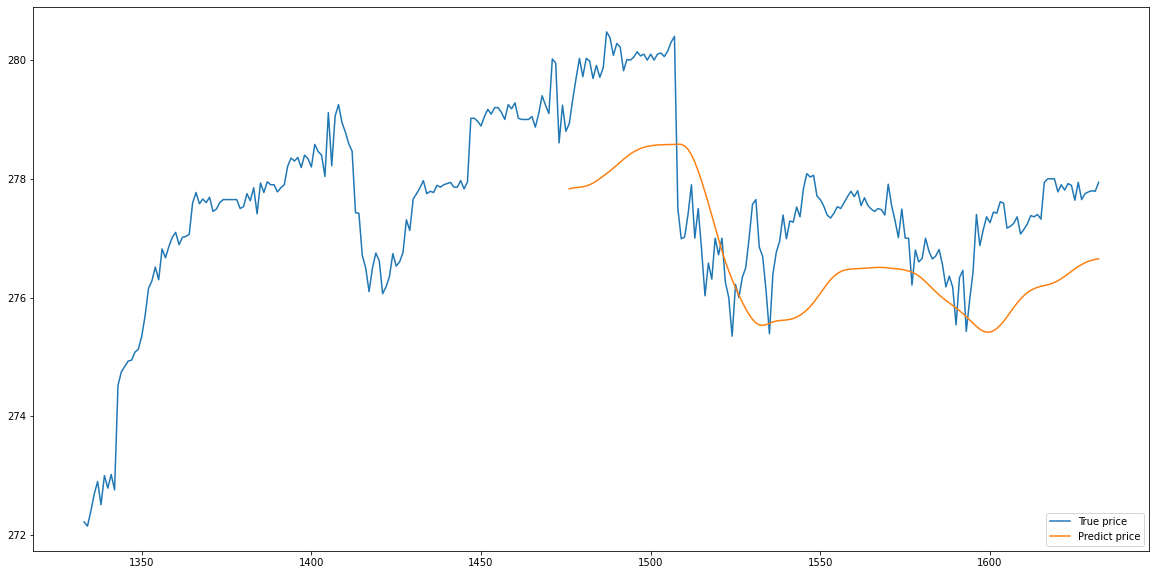

In [263]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [264]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 2.4888e+02, -9.1170e-01],
       [ 2.4864e+02, -8.7310e-01],
       [ 2.4869e+02, -9.1640e-01],
       ...,
       [ 2.7780e+02,  2.3450e-01],
       [ 2.7779e+02,  1.9840e-01],
       [ 2.7794e+02,  2.0190e-01]])

In [265]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.15385645, 0.21469751],
       [0.14742903, 0.22363455],
       [0.14876808, 0.21360932],
       ...,
       [0.92836101, 0.48007687],
       [0.9280932 , 0.47171865],
       [0.93211034, 0.472529  ]])

In [266]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1573
1573


In [267]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (1259, 60, 2)
Size validate:  (157, 60, 2)
Size test:  (157, 60, 2)


In [268]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

Epoch 1/25
40/40 [==============================] - 13s 150ms/step - loss: 0.0696 - val_loss: 0.0138
Epoch 2/25
40/40 [==============================] - 4s 113ms/step - loss: 0.0046 - val_loss: 0.0063
Epoch 3/25
40/40 [==============================] - 5s 113ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 4/25
40/40 [==============================] - 5s 113ms/step - loss: 0.0036 - val_loss: 0.0137
Epoch 5/25
40/40 [==============================] - 5s 113ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 6/25
40/40 [==============================] - 5s 116ms/step - loss: 0.0025 - val_loss: 0.0050
Epoch 7/25
40/40 [==============================] - 5s 136ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 8/25
40/40 [==============================] - 5s 117ms/step - loss: 0.0024 - val_loss: 0.0105
Epoch 9/25
40/40 [==============================] - 5s 119ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 10/25
40/40 [==============================] - 5s 120ms/step - loss: 0.0023 - val_loss: 0.004

In [269]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [270]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]
predictions

array([278.84494, 278.798  , 278.7993 , 278.8427 , 278.9416 , 279.02545,
       279.14197, 279.25674, 279.33328, 279.40576, 279.44574, 279.49097,
       279.57593, 279.6489 , 279.69604, 279.7533 , 279.75754, 279.71362,
       279.73737, 279.7435 , 279.77222, 279.80518, 279.81076, 279.79248,
       279.74286, 279.71344, 279.67044, 279.64273, 279.64252, 279.638  ,
       279.65396, 279.68268, 279.6966 , 279.44083, 279.05527, 278.61978,
       278.2312 , 277.96295, 277.6735 , 277.45724, 277.21982, 276.91684,
       276.66757, 276.43002, 276.29453, 276.1833 , 276.13217, 276.03464,
       275.9012 , 275.69815, 275.5594 , 275.42722, 275.34357, 275.46252,
       275.7137 , 276.04727, 276.36966, 276.55203, 276.68323, 276.6783 ,
       276.57108, 276.5469 , 276.55026, 276.59973, 276.67023, 276.7257 ,
       276.78452, 276.8762 , 277.00558, 277.15237, 277.28687, 277.44174,
       277.56693, 277.66574, 277.68796, 277.64578, 277.57013, 277.51523,
       277.47333, 277.476  , 277.5384 , 277.5607 , 

In [271]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-271-665481fb171d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,date,open,high,low,close,volume,ROC,SMA,RSI,Real Middle Band,Real Lower Band,Real Upper Band,predictions
1476,2021-07-07 11:30:00,278.8400,278.97,278.5500,278.9300,624508.0,-0.0681,279.1518,51.1594,279.1518,278.4927,279.8108,278.844940
1477,2021-07-07 11:45:00,278.9450,279.35,278.5200,279.3314,570070.0,0.1188,279.1683,54.7801,279.1683,278.5087,279.8279,278.798004
1478,2021-07-07 12:00:00,279.3200,279.98,279.3200,279.6900,510257.0,0.1576,279.1903,57.7271,279.1903,278.4930,279.8876,278.799286
1479,2021-07-07 12:15:00,279.7050,280.23,279.6600,280.0300,527682.0,0.3045,279.2328,60.3087,279.2328,278.4454,280.0202,278.842712
1480,2021-07-07 12:30:00,280.0500,280.24,279.7000,279.7200,661221.0,0.1575,279.2548,56.9696,279.2548,278.4393,280.0703,278.941589
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,2021-07-09 19:00:00,277.7499,277.75,277.7499,277.7500,1611.0,0.1406,277.6570,53.8171,277.6570,277.0466,278.2674,277.623566
1629,2021-07-09 19:15:00,277.7800,277.78,277.7800,277.7800,220.0,0.2563,277.6925,54.1876,277.6925,277.1432,278.2418,277.627594
1630,2021-07-09 19:30:00,277.7900,277.80,277.7900,277.8000,1053.0,0.2345,277.7250,54.4440,277.7250,277.2341,278.2159,277.645020
1631,2021-07-09 19:45:00,277.8000,277.80,277.7900,277.7900,1233.0,0.1984,277.7525,54.2841,277.7525,277.3146,278.1904,277.661713


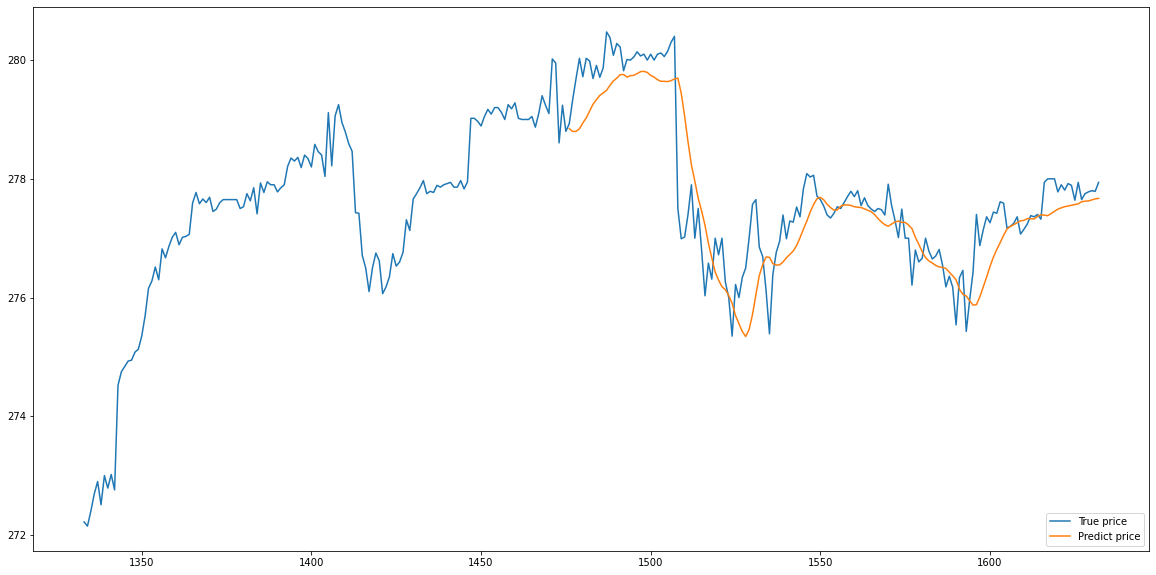

In [272]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### a. Prepare Input

In [309]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume']]
dataset

,close,volume
0,248.88,815307.0
1,248.64,1142659.0
2,248.69,822538.0
3,247.95,850538.0
4,248.12,1663982.0
...,...,...
1628,277.75,1611.0
1629,277.78,220.0
1630,277.80,1053.0
1631,277.79,1233.0


In [310]:
for i in range (1, 6):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

<ipython-input-310-b37348da400b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-310-b37348da400b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)


,close,volume,close_date_1,volume_date_1,close_date_2,volume_date_2,close_date_3,volume_date_3,close_date_4,volume_date_4,close_date_5,volume_date_5
0,248.88,815307.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,248.64,1142659.0,248.88,815307.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,248.69,822538.0,248.64,1142659.0,248.88,815307.0,NaN,NaN,NaN,NaN,NaN,NaN
3,247.95,850538.0,248.69,822538.0,248.64,1142659.0,248.88,815307.0,NaN,NaN,NaN,NaN
4,248.12,1663982.0,247.95,850538.0,248.69,822538.0,248.64,1142659.0,248.88,815307.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1628,277.75,1611.0,277.65,4209.0,277.94,200.0,277.64,2232.0,277.89,205.0,277.92,1088.0
1629,277.78,220.0,277.75,1611.0,277.65,4209.0,277.94,200.0,277.64,2232.0,277.89,205.0
1630,277.80,1053.0,277.78,220.0,277.75,1611.0,277.65,4209.0,277.94,200.0,277.64,2232.0
1631,277.79,1233.0,277.80,1053.0,277.78,220.0,277.75,1611.0,277.65,4209.0,277.94,200.0


In [311]:
dataset.dropna(inplace=True)
dataset

,close,volume,close_date_1,volume_date_1,close_date_2,volume_date_2,close_date_3,volume_date_3,close_date_4,volume_date_4,close_date_5,volume_date_5
5,248.51,1965033.0,248.12,1663982.0,247.95,850538.0,248.69,822538.0,248.64,1142659.0,248.88,815307.0
6,248.31,516271.0,248.51,1965033.0,248.12,1663982.0,247.95,850538.0,248.69,822538.0,248.64,1142659.0
7,248.33,473400.0,248.31,516271.0,248.51,1965033.0,248.12,1663982.0,247.95,850538.0,248.69,822538.0
8,248.00,494770.0,248.33,473400.0,248.31,516271.0,248.51,1965033.0,248.12,1663982.0,247.95,850538.0
9,248.22,502159.0,248.00,494770.0,248.33,473400.0,248.31,516271.0,248.51,1965033.0,248.12,1663982.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1628,277.75,1611.0,277.65,4209.0,277.94,200.0,277.64,2232.0,277.89,205.0,277.92,1088.0
1629,277.78,220.0,277.75,1611.0,277.65,4209.0,277.94,200.0,277.64,2232.0,277.89,205.0
1630,277.80,1053.0,277.78,220.0,277.75,1611.0,277.65,4209.0,277.94,200.0,277.64,2232.0
1631,277.79,1233.0,277.80,1053.0,277.78,220.0,277.75,1611.0,277.65,4209.0,277.94,200.0


In [312]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1628, 10)
(1628, 1)


,close_date_1,volume_date_1,close_date_2,volume_date_2,close_date_3,volume_date_3,close_date_4,volume_date_4,close_date_5,volume_date_5
5,248.12,1663982.0,247.95,850538.0,248.69,822538.0,248.64,1142659.0,248.88,815307.0
6,248.51,1965033.0,248.12,1663982.0,247.95,850538.0,248.69,822538.0,248.64,1142659.0
7,248.31,516271.0,248.51,1965033.0,248.12,1663982.0,247.95,850538.0,248.69,822538.0
8,248.33,473400.0,248.31,516271.0,248.51,1965033.0,248.12,1663982.0,247.95,850538.0
9,248.00,494770.0,248.33,473400.0,248.31,516271.0,248.51,1965033.0,248.12,1663982.0
...,...,...,...,...,...,...,...,...,...,...
1628,277.65,4209.0,277.94,200.0,277.64,2232.0,277.89,205.0,277.92,1088.0
1629,277.75,1611.0,277.65,4209.0,277.94,200.0,277.64,2232.0,277.89,205.0
1630,277.78,220.0,277.75,1611.0,277.65,4209.0,277.94,200.0,277.64,2232.0
1631,277.80,1053.0,277.78,220.0,277.75,1611.0,277.65,4209.0,277.94,200.0


In [313]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1466, 10)
Size test:  (162, 10)


### b. Train Model

In [314]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [315]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [316]:
predictions = model_xgboost.predict(X_test)
predictions

array([278.7094 , 278.7561 , 278.7219 , 278.46884, 278.62613, 278.3937 ,
       278.56406, 278.59274, 278.63843, 278.57153, 278.62155, 278.62155,
       278.57153, 278.56024, 278.6165 , 278.56024, 278.56024, 278.60022,
       278.62155, 278.6122 , 278.57153, 278.58087, 278.58087, 278.62155,
       278.65436, 278.55695, 278.5691 , 278.61627, 278.46692, 278.56903,
       278.56903, 278.53143, 278.4943 , 278.4943 , 278.5245 , 278.53143,
       278.53143, 278.52112, 277.8176 , 277.3536 , 277.41205, 277.42758,
       277.97864, 277.38916, 277.49265, 277.2171 , 276.40768, 276.77515,
       276.77515, 276.93353, 276.6774 , 277.14536, 276.59125, 276.40768,
       276.24557, 276.4935 , 276.0981 , 276.46558, 276.6774 , 276.93353,
       277.38507, 277.59787, 276.93243, 276.7042 , 276.33234, 275.9444 ,
       276.56345, 276.6561 , 276.6661 , 277.28403, 277.1649 , 277.40326,
       277.35953, 277.57944, 277.55   , 277.8814 , 278.1358 , 278.13004,
       278.17227, 277.79886, 277.7902 , 277.75458, 

In [317]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-317-88868e85d37d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,close,volume,close_date_1,volume_date_1,close_date_2,volume_date_2,close_date_3,volume_date_3,close_date_4,volume_date_4,close_date_5,volume_date_5,predictions
1471,280.020,1491561.0,279.100,1229749.0,279.240,2016357.0,279.40,39330.0,279.10,10193.0,278.87,16840.0,278.709412
1472,279.950,1279550.0,280.020,1491561.0,279.100,1229749.0,279.24,2016357.0,279.40,39330.0,279.10,10193.0,278.756104
1473,278.605,1242721.0,279.950,1279550.0,280.020,1491561.0,279.10,1229749.0,279.24,2016357.0,279.40,39330.0,278.721893
1474,279.240,1037979.0,278.605,1242721.0,279.950,1279550.0,280.02,1491561.0,279.10,1229749.0,279.24,2016357.0,278.468842
1475,278.800,787849.0,279.240,1037979.0,278.605,1242721.0,279.95,1279550.0,280.02,1491561.0,279.10,1229749.0,278.626129
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,277.750,1611.0,277.650,4209.0,277.940,200.0,277.64,2232.0,277.89,205.0,277.92,1088.0,277.769196
1629,277.780,220.0,277.750,1611.0,277.650,4209.0,277.94,200.0,277.64,2232.0,277.89,205.0,277.611359
1630,277.800,1053.0,277.780,220.0,277.750,1611.0,277.65,4209.0,277.94,200.0,277.64,2232.0,278.031372
1631,277.790,1233.0,277.800,1053.0,277.780,220.0,277.75,1611.0,277.65,4209.0,277.94,200.0,277.862213


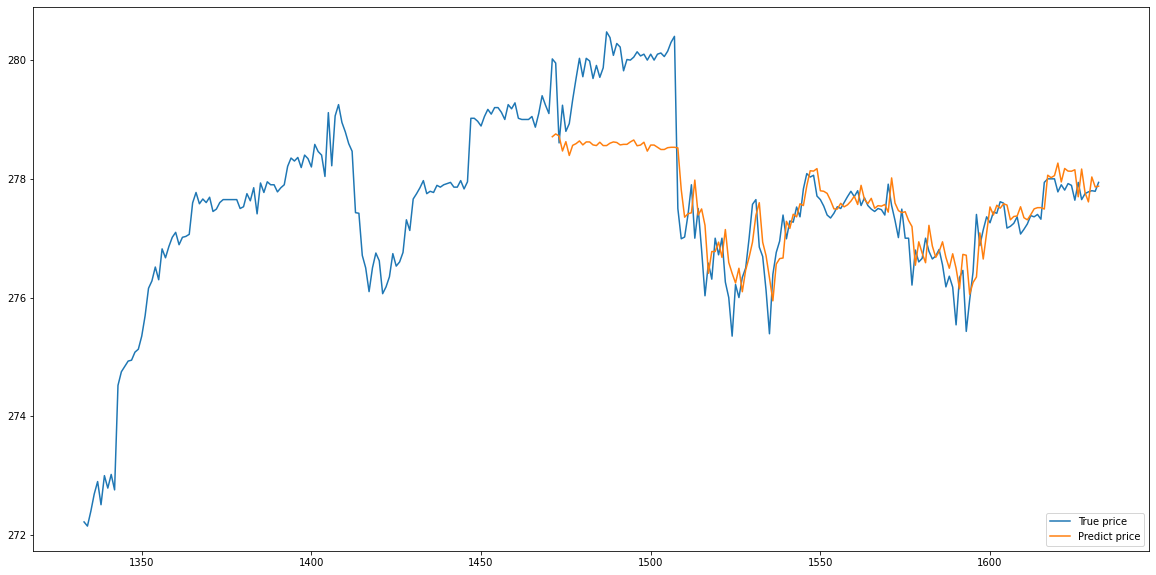

In [318]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [319]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

,close,volume,ROC
0,248.88,815307.0,-0.9117
1,248.64,1142659.0,-0.8731
2,248.69,822538.0,-0.9164
3,247.95,850538.0,-1.3527
4,248.12,1663982.0,-1.2615
...,...,...,...
1628,277.75,1611.0,0.1406
1629,277.78,220.0,0.2563
1630,277.80,1053.0,0.2345
1631,277.79,1233.0,0.1984


In [320]:
for i in range (1, 6):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

<ipython-input-320-1a445576bd9e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["close_date_" + str(i)] = dataset.close.shift(i)
<ipython-input-320-1a445576bd9e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
<ipython-input-320-1a445576bd9e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://p

,close,volume,ROC,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2,close_date_3,volume_date_3,ROC_date_3,close_date_4,volume_date_4,ROC_date_4,close_date_5,volume_date_5,ROC_date_5
0,248.88,815307.0,-0.9117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,248.64,1142659.0,-0.8731,248.88,815307.0,-0.9117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,248.69,822538.0,-0.9164,248.64,1142659.0,-0.8731,248.88,815307.0,-0.9117,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,247.95,850538.0,-1.3527,248.69,822538.0,-0.9164,248.64,1142659.0,-0.8731,248.88,815307.0,-0.9117,NaN,NaN,NaN,NaN,NaN,NaN
4,248.12,1663982.0,-1.2615,247.95,850538.0,-1.3527,248.69,822538.0,-0.9164,248.64,1142659.0,-0.8731,248.88,815307.0,-0.9117,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670,277.64,2232.0,0.1696,277.89,205.0,0.1081,277.92,1088.0,0.1102
1629,277.78,220.0,0.2563,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670,277.64,2232.0,0.1696,277.89,205.0,0.1081
1630,277.80,1053.0,0.2345,277.78,220.0,0.2563,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670,277.64,2232.0,0.1696
1631,277.79,1233.0,0.1984,277.80,1053.0,0.2345,277.78,220.0,0.2563,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670


In [321]:
dataset.dropna(inplace=True)
dataset

,close,volume,ROC,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2,close_date_3,volume_date_3,ROC_date_3,close_date_4,volume_date_4,ROC_date_4,close_date_5,volume_date_5,ROC_date_5
5,248.51,1965033.0,-0.9920,248.12,1663982.0,-1.2615,247.95,850538.0,-1.3527,248.69,822538.0,-0.9164,248.64,1142659.0,-0.8731,248.88,815307.0,-0.9117
6,248.31,516271.0,-0.9336,248.51,1965033.0,-0.9920,248.12,1663982.0,-1.2615,247.95,850538.0,-1.3527,248.69,822538.0,-0.9164,248.64,1142659.0,-0.8731
7,248.33,473400.0,-0.9058,248.31,516271.0,-0.9336,248.51,1965033.0,-0.9920,248.12,1663982.0,-1.2615,247.95,850538.0,-1.3527,248.69,822538.0,-0.9164
8,248.00,494770.0,-1.0573,248.33,473400.0,-0.9058,248.31,516271.0,-0.9336,248.51,1965033.0,-0.9920,248.12,1663982.0,-1.2615,247.95,850538.0,-1.3527
9,248.22,502159.0,-1.0090,248.00,494770.0,-1.0573,248.33,473400.0,-0.9058,248.31,516271.0,-0.9336,248.51,1965033.0,-0.9920,248.12,1663982.0,-1.2615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670,277.64,2232.0,0.1696,277.89,205.0,0.1081,277.92,1088.0,0.1102
1629,277.78,220.0,0.2563,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670,277.64,2232.0,0.1696,277.89,205.0,0.1081
1630,277.80,1053.0,0.2345,277.78,220.0,0.2563,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670,277.64,2232.0,0.1696
1631,277.79,1233.0,0.1984,277.80,1053.0,0.2345,277.78,220.0,0.2563,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670


In [322]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1628, 15)
(1628, 1)


,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2,close_date_3,volume_date_3,ROC_date_3,close_date_4,volume_date_4,ROC_date_4,close_date_5,volume_date_5,ROC_date_5
5,248.12,1663982.0,-1.2615,247.95,850538.0,-1.3527,248.69,822538.0,-0.9164,248.64,1142659.0,-0.8731,248.88,815307.0,-0.9117
6,248.51,1965033.0,-0.9920,248.12,1663982.0,-1.2615,247.95,850538.0,-1.3527,248.69,822538.0,-0.9164,248.64,1142659.0,-0.8731
7,248.31,516271.0,-0.9336,248.51,1965033.0,-0.9920,248.12,1663982.0,-1.2615,247.95,850538.0,-1.3527,248.69,822538.0,-0.9164
8,248.33,473400.0,-0.9058,248.31,516271.0,-0.9336,248.51,1965033.0,-0.9920,248.12,1663982.0,-1.2615,247.95,850538.0,-1.3527
9,248.00,494770.0,-1.0573,248.33,473400.0,-0.9058,248.31,516271.0,-0.9336,248.51,1965033.0,-0.9920,248.12,1663982.0,-1.2615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,277.65,4209.0,0.1443,277.94,200.0,0.2670,277.64,2232.0,0.1696,277.89,205.0,0.1081,277.92,1088.0,0.1102
1629,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670,277.64,2232.0,0.1696,277.89,205.0,0.1081
1630,277.78,220.0,0.2563,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670,277.64,2232.0,0.1696
1631,277.80,1053.0,0.2345,277.78,220.0,0.2563,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670


In [323]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1466, 15)
Size test:  (162, 15)


In [324]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=2, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [325]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [326]:
predictions = model.predict(X_test)
predictions

array([278.66092, 278.4952 , 278.4901 , 278.2789 , 278.34763, 278.33243,
       278.33987, 278.48117, 278.43646, 278.45135, 278.5242 , 278.4795 ,
       278.46402, 278.51334, 278.526  , 278.55566, 278.57684, 278.48026,
       278.63327, 278.45135, 278.57776, 278.47775, 278.5877 , 278.62094,
       278.488  , 278.46753, 278.52332, 278.38312, 278.50275, 278.56158,
       278.4987 , 278.47974, 278.443  , 278.443  , 278.47223, 278.47974,
       278.47974, 278.46857, 277.87613, 277.3826 , 277.41852, 277.40198,
       277.93042, 277.44043, 277.44037, 277.2219 , 276.4117 , 276.77917,
       276.77917, 276.93756, 276.68143, 277.14938, 276.59528, 276.4117 ,
       276.24667, 276.49753, 276.10214, 276.4696 , 276.66876, 277.01297,
       277.4174 , 277.55615, 276.88785, 276.61316, 276.42117, 275.9741 ,
       276.60934, 276.7164 , 276.68048, 277.27747, 277.09903, 277.34845,
       277.36008, 277.50668, 277.53082, 277.90176, 278.1162 , 278.0065 ,
       278.13632, 277.91412, 277.8341 , 277.78735, 

In [327]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

<ipython-input-327-88868e85d37d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_df['predictions'] = predictions


,close,volume,ROC,close_date_1,volume_date_1,ROC_date_1,close_date_2,volume_date_2,ROC_date_2,close_date_3,volume_date_3,ROC_date_3,close_date_4,volume_date_4,ROC_date_4,close_date_5,volume_date_5,ROC_date_5,predictions
1471,280.020,1491561.0,0.3476,279.100,1229749.0,0.0753,279.240,2016357.0,0.0968,279.40,39330.0,0.1362,279.10,10193.0,0.0287,278.87,16840.0,0.3310,278.660919
1472,279.950,1279550.0,0.2794,280.020,1491561.0,0.3476,279.100,1229749.0,0.0753,279.24,2016357.0,0.0968,279.40,39330.0,0.1362,279.10,10193.0,0.0287,278.495209
1473,278.605,1242721.0,-0.1738,279.950,1279550.0,0.2794,280.020,1491561.0,0.3476,279.10,1229749.0,0.0753,279.24,2016357.0,0.0968,279.40,39330.0,0.1362,278.490112
1474,279.240,1037979.0,0.0143,278.605,1242721.0,-0.1738,279.950,1279550.0,0.2794,280.02,1491561.0,0.3476,279.10,1229749.0,0.0753,279.24,2016357.0,0.0968,278.278900
1475,278.800,787849.0,-0.1433,279.240,1037979.0,0.0143,278.605,1242721.0,-0.1738,279.95,1279550.0,0.2794,280.02,1491561.0,0.3476,279.10,1229749.0,0.0753,278.347626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1628,277.750,1611.0,0.1406,277.650,4209.0,0.1443,277.940,200.0,0.2670,277.64,2232.0,0.1696,277.89,205.0,0.1081,277.92,1088.0,0.1102,277.713837
1629,277.780,220.0,0.2563,277.750,1611.0,0.1406,277.650,4209.0,0.1443,277.94,200.0,0.2670,277.64,2232.0,0.1696,277.89,205.0,0.1081,277.672089
1630,277.800,1053.0,0.2345,277.780,220.0,0.2563,277.750,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670,277.64,2232.0,0.1696,278.005615
1631,277.790,1233.0,0.1984,277.800,1053.0,0.2345,277.780,220.0,0.2563,277.75,1611.0,0.1406,277.65,4209.0,0.1443,277.94,200.0,0.2670,277.878479


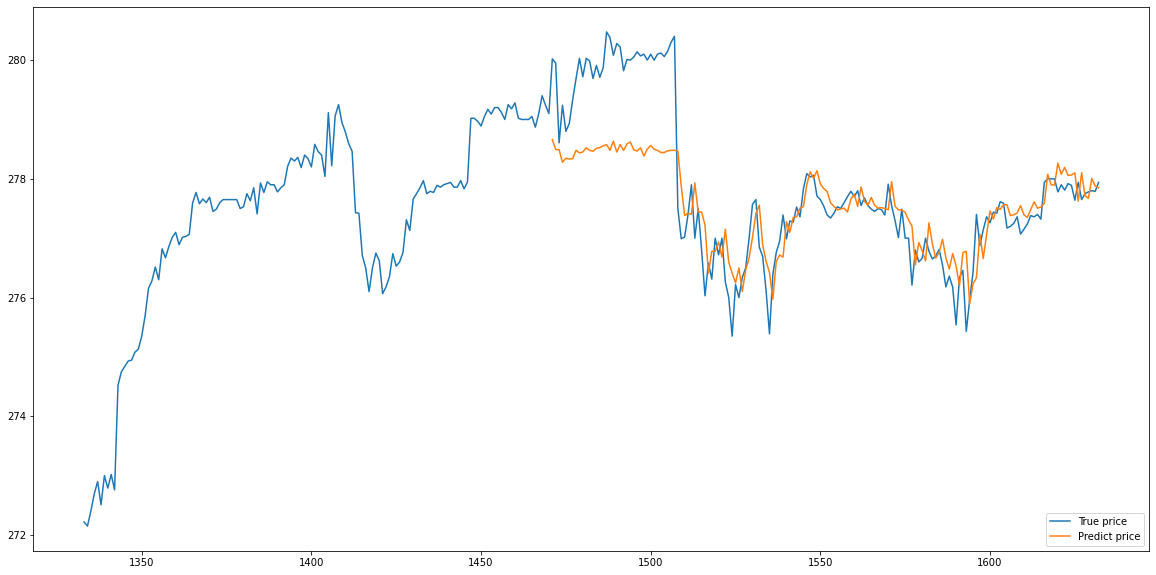

In [328]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Predict Future

In [329]:
def xgboost_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.dat'
    model = pickle.load(open(modelFileName, "rb"))
    numDataPoint = int(period / 15)
    
    temp = indicatorArr.copy()
    temp.append('volume')
    data = data[temp]
    data = data[-5:]
    
    X = pd.DataFrame({})
    for column in data.columns:
        n = len(data)
        for i in range(1, n + 1):
            X[column + '_date_' + str(i)] = [data.iloc[n - i][column]] 
    
    predictedValue = model.predict(X)
    
    return predictedValue